In [20]:
import matplotlib.pyplot as plt
import fenics as fe
import mshr
import numpy as np
from scipy.linalg import eigh

In [21]:
# Constants
CENTER = fe.Point(0, 0)
RADIUS = 1
DOMAIN = mshr.Circle(CENTER, RADIUS)
RHS_F = fe.Constant(1)
DIRICHLET_BC = fe.Constant(0)

In [22]:
def cov1_1(x, y):
    return 5.0/100.0 * np.exp(-4.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))
def cov1_2(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((2*x[0] - y[0])**2 + (2*x[1] - y[1])**2))
def cov2_1(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((x[0] - 2*y[0])**2 + (x[1] - 2*y[1])**2))
def cov2_2(x, y):
    return 5.0/100.0 * np.exp(-1.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))

In [23]:
# Helpers eigenpair calculation
class BasisFunction():
    def __init__(self, basis_function: fe.Function, coordinates: np.array):
        self.function = basis_function
        self.coordinates = coordinates

def get_max_edge_length(mesh):
    max_length = 0
    for cell in fe.cells(mesh):
        vertices = np.array(cell.get_vertex_coordinates()).reshape((-1, 2))
        edge_lengths = np.linalg.norm(np.roll(vertices, -1, axis=0) - vertices, axis=1)
        max_length = max(max_length, np.max(edge_lengths))
    return max_length

def get_C_entry(mc_samples_for_c_entries, f, basis_function_i: BasisFunction, basis_function_j: BasisFunction, max_edge_length: float):
    def integrand(x, y):
        return f(x, y) * basis_function_i.function(x) * basis_function_j.function(y)
    # generate MC samples
    angles_x = np.random.uniform(0, 2 * np.pi, mc_samples_for_c_entries)
    radii_x = np.sqrt(np.random.uniform(0, max_edge_length, mc_samples_for_c_entries))
    x1_samples = basis_function_i.coordinates[0] + radii_x * np.cos(angles_x)
    x2_samples = basis_function_i.coordinates[1] + radii_x * np.sin(angles_x)
    angles_y = np.random.uniform(0, 2 * np.pi, mc_samples_for_c_entries)
    radii_y = np.sqrt(np.random.uniform(0, max_edge_length, mc_samples_for_c_entries))
    y1_samples = basis_function_j.coordinates[0] + radii_y * np.cos(angles_y)
    y2_samples = basis_function_j.coordinates[1] + radii_y * np.sin(angles_y)
    C_entry = 0
    for (x1, x2) in zip(x1_samples, x2_samples):
        for (y1, y2) in zip(y1_samples, y2_samples):
            C_entry += integrand([x1, x2], [y1, y2])
    return C_entry / (mc_samples_for_c_entries**2) * np.pi * max_edge_length**2

def calculate_vector_field_eigenpairs(mesh_resolution_c_entries, mc_samples_for_c_entries):  
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_c_entries)
    max_edge_length = get_max_edge_length(mesh)
    V = fe.FunctionSpace(mesh, "CG", 1)
    V_Vector = fe.VectorFunctionSpace(mesh, "CG", 1)
    N = V.dim()
    dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, 2))

    basis_functions = []
    basis_functions_grads = []
    for i in range(N):
        basis_function = fe.Function(V)
        basis_function.vector()[i] = 1.0
        basis_function.set_allow_extrapolation(True)
        basis_functions.append(BasisFunction(basis_function, dof_coordinates[i]))
        grad = fe.project(fe.grad(basis_function), V_Vector)
        grad.set_allow_extrapolation(True)
        basis_functions_grads.append(BasisFunction(grad, dof_coordinates[i]))

    C = np.zeros((2 * N, 2 * N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if j <= i:
                # Here we use that each block is symmetric because of the symmetry of the covariance functions
                C[i, j] = C[j, i] = get_C_entry(mc_samples_for_c_entries, cov1_1, basis_function_i, basis_function_j, max_edge_length)
                C[i, N + j] = C[j, N + i] = get_C_entry(mc_samples_for_c_entries, cov1_2, basis_function_i, basis_function_j, max_edge_length)
                C[N + i, j] = C[N + j, i] = get_C_entry(mc_samples_for_c_entries, cov2_1, basis_function_i, basis_function_j, max_edge_length)
                C[N + i, N + j] = C[N + j, N + i] = get_C_entry(mc_samples_for_c_entries, cov2_2, basis_function_i, basis_function_j, max_edge_length)
    # print(f"C: {C}")

    M = np.zeros((2 * N, 2 * N))
    for i, basis_function in enumerate(basis_functions):
        integrand = basis_function.function * basis_function.function * fe.dx
        M[i, i] = M[N + i, N + i] = fe.assemble(integrand)
    # print(f"M: {M}")


    J = N # Number of eigenvectors -> J = N is maximum
    eigenvalues, eigenvectors = eigh(C, M, subset_by_index=[0, J-1])
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Print the eigenvalues and eigenvectors -> important to test if MC-sample size is large enough
    # print(f"Eigenvalues: {sorted_eigenvalues}")
    # print(f"Eigenvectors: {sorted_eigenvectors}")

    # Eliminate negative eigenvalues
    for index, sorted_eigenvalue in enumerate(sorted_eigenvalues):
        if sorted_eigenvalue < 0:
            sorted_eigenvalues[index] = 0
    return sorted_eigenvalues, sorted_eigenvectors, basis_functions_grads, N, J

In [24]:
###### Section 1 ######
###### Calculation of the eigenpairs for the random field ###### 

# Inputs
# 3, 100 takes approximately 5 minutes
# 4, 180 takes approximately 36 minutes
mesh_resolution_c_entries = 4
mc_samples_for_c_entries = 180

# Calculate the eigenpairs
eigenvalues, eigenvectors, basis_functions_grads, N, J = calculate_vector_field_eigenpairs(mesh_resolution_c_entries, mc_samples_for_c_entries)

  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 121 nodes for 61 points.


In [25]:
# Helpers sampling
def random_field(x, eigenvalues, eigenvectors, xi, basis_functions, N, J):
    return x[0] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)]), \
           x[1] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)])

def jacobian(x, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J):
    jacobian_output = np.zeros((2, 2))
    jacobian_output[0, 0] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[0, 1] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 0] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[1] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 1] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    return jacobian_output

In [26]:
# Helpers single MC global

class AExpression(fe.UserExpression):
    def __init__(self, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J, **kwargs):
        super().__init__(**kwargs)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.xi = xi
        self.basis_functions_grads = basis_functions_grads
        self.N = N
        self.J = J

    def eval(self, values, x):
        J_x = jacobian(x, self.eigenvalues, self.eigenvectors, self.xi, self.basis_functions_grads, self.N, self.J)
        inv_JTJ = np.linalg.inv(J_x.T @ J_x)
        det_J = np.linalg.det(J_x)
        A_x = inv_JTJ * det_J
        values[0] = A_x[0, 0]
        values[1] = A_x[0, 1]
        values[2] = A_x[1, 0]
        values[3] = A_x[1, 1]

    def value_shape(self):
        return (2, 2)
    
def solve_poisson_for_given_sample(mesh_resolution, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution)
    V = fe.FunctionSpace(mesh, "CG", 3) #! degree 3
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    A_expr = AExpression(eigenvalues, eigenvectors, xi, basis_functions_grads, N, J, degree=2)
    a = fe.inner(fe.dot(A_expr, fe.grad(u)), fe.grad(v)) * fe.dx
    L = RHS_F * v * fe.dx
    bc = fe.DirichletBC(V, DIRICHLET_BC, 'on_boundary')
    u_sol = fe.Function(V)
    fe.solve(a == L, u_sol, bc)
    return u_sol

def mc_single_global_calculation(mc_samples_single, mesh_resolution_fem_single):
    u_sols = []
    for i in range(mc_samples_single):
        print(f"Iteration {i+1}/{mc_samples_single}")
        xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), J)
        u_sols.append(solve_poisson_for_given_sample(mesh_resolution_fem_single, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J))

    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_fem_single)
    V = fe.FunctionSpace(mesh, "CG", 3) #! degree 3
    mean_sol = fe.Function(V)
    mean_sol.vector()[:] = 0
    for u_sol in u_sols:
        mean_sol.vector()[:] += u_sol.vector() / mc_samples_single
        # c = fe.plot(u_sol, title='Solution')
        # plt.colorbar(c)
        # plt.show()

    #! Not sure about the variance calculation in the degrees of freedom
    var_sol = fe.Function(V)
    var_sol.vector()[:] = 0
    for u_sol in u_sols:
        for dof_index in range(len(u_sol.vector())):
            if mc_samples_single > 1:
                var_sol.vector()[dof_index] += (u_sol.vector()[dof_index] - mean_sol.vector()[dof_index])**2 / (mc_samples_single-1)
    return mean_sol, var_sol

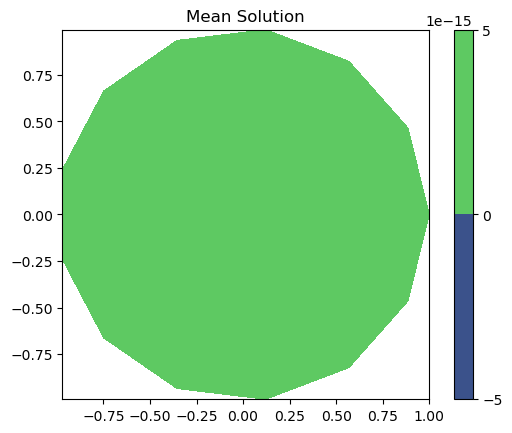

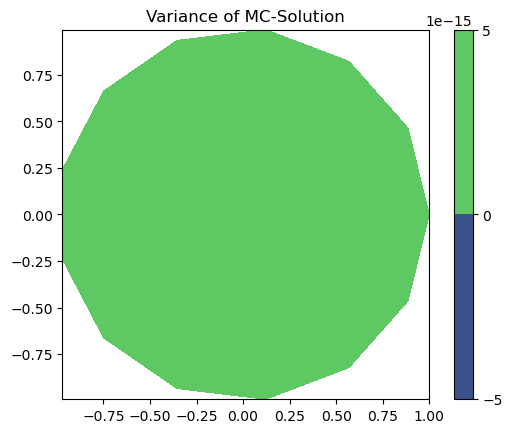

In [27]:
###### Section 2 ######
###### Single MC-loop Calculation of samples of the vector field saved globally ######

# Inputs
# 5, 4 takes approximately 4 minutes
mc_samples_single = 0
mesh_resolution_fem_single = 4

# Calling the function
mean_sol, var_sol = mc_single_global_calculation(mc_samples_single, mesh_resolution_fem_single)

#Plots
c = fe.plot(mean_sol, title='Mean Solution')
plt.colorbar(c)
plt.show()

c = fe.plot(var_sol, title='Variance of MC-Solution')
plt.colorbar(c)
plt.show()

In [28]:
# Helpers for multiple mc loops local analysis

def true_sol(mesh_resolution_fem_true_sol):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_fem_true_sol)
    V = fe.FunctionSpace(mesh, "CG", 3) # Consider higher order if mc simulations are more accurate
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    ref_a = fe.inner(fe.grad(u), fe.grad(v)) * fe.dx
    L = RHS_F * v * fe.dx
    bc = fe.DirichletBC(V, DIRICHLET_BC, 'on_boundary')
    u_true_sol = fe.Function(V)
    fe.solve(ref_a == L, u_true_sol, bc)
    return u_true_sol

def mc_multiple_local_calculation(mc_samples_multiple, mesh_resolution_fem_multiple, mesh_resolution_fem_true_sol, P):
    u_sols_in_point_P_mean = np.zeros(len(mc_samples_multiple))
    u_sols_in_point_P_var = np.zeros(len(mc_samples_multiple))
    L_2_errors = np.zeros(len(mc_samples_multiple))
    H_1_errors = np.zeros(len(mc_samples_multiple))
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_fem_multiple)
    V = fe.FunctionSpace(mesh, "CG", 3) #! degree 3
    u_true_sol = true_sol(mesh_resolution_fem_true_sol)

    for mc_sample_size_index, mc_sample_size in enumerate(mc_samples_multiple):
        u_sols_in_point_P = []
        mean_sol = fe.Function(V)
        mean_sol.vector()[:] = 0
        for i in range(mc_sample_size):
            print(f"Iteration {i+1}/{mc_sample_size}")
            xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), J)
            u_sol = solve_poisson_for_given_sample(mesh_resolution_fem_multiple, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J)
            u_sols_in_point_P.append(u_sol(P))
            mean_sol.vector()[:] += u_sol.vector() / mc_sample_size

        #! Plot of means
        c = fe.plot(mean_sol, title='Solution with MC-sample size ' + str(mc_sample_size))
        plt.colorbar(c)
        plt.show()

        u_sols_in_point_P_mean[mc_sample_size_index] = np.mean(u_sols_in_point_P)
        u_sols_in_point_P_var[mc_sample_size_index] = np.var(u_sols_in_point_P)
        L_2_errors[mc_sample_size_index] = fe.errornorm(u_true_sol, mean_sol, norm_type='L2')
        H_1_errors[mc_sample_size_index] = fe.errornorm(u_true_sol, mean_sol, norm_type='H1')
    return u_sols_in_point_P_mean, u_sols_in_point_P_var, L_2_errors, H_1_errors, u_true_sol(P)

Iteration 1/1  Solving linear variational problem.

  Solving linear variational problem.


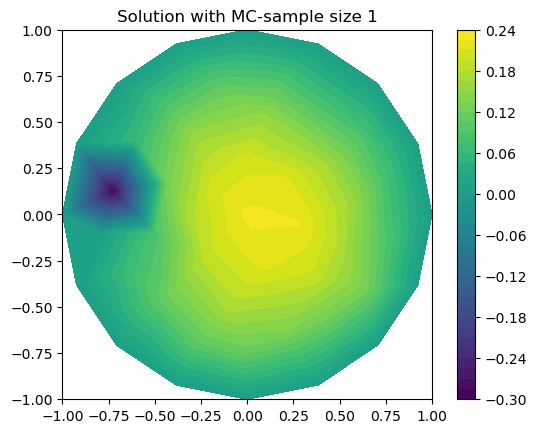

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iteration 1/2
  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 177 nodes for 89 points.
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
  Solving linear variational problem.
Iteration 2/2
  Solving linear variational problem.


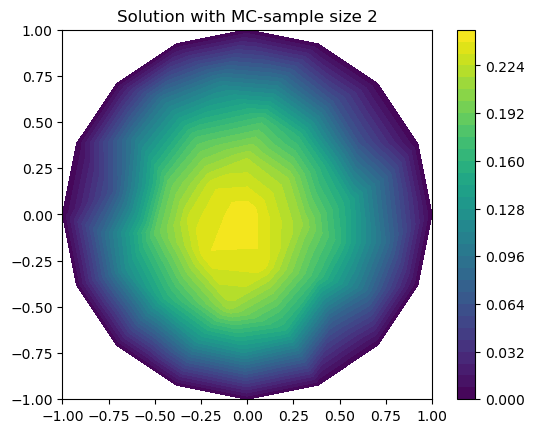

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iteration 1/4
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
  Solving linear variational problem.
Iteration 2/4
  Solving linear variational problem.
Iteration 3/4
  Solving linear variational problem.
Iteration 4/4
  Solving linear variational problem.


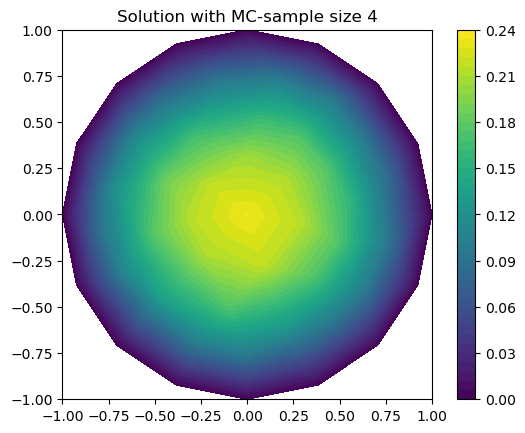

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iteration 1/8
  Solving linear variational problem.
Iteration 2/8
  Solving linear variational problem.
Iteration 3/8
  Solving linear variational problem.
Iteration 4/8
  Solving linear variational problem.
Iteration 5/8
  Solving linear variational problem.
Iteration 6/8
  Solving linear variational problem.
Iteration 7/8
  Solving linear variational problem.
Iteration 8/8
  Solving linear variational problem.


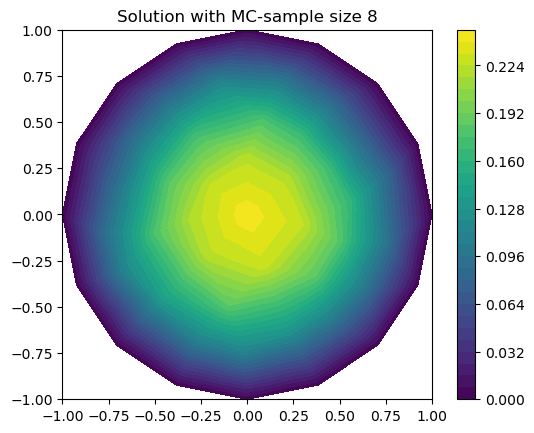

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iteration 1/16
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
  Solving linear variational problem.
Iteration 2/16
  Solving linear variational problem.
Iteration 3/16
  Solving linear variational problem.
Iteration 4/16
  Solving linear variational problem.
Iteration 5/16
  Solving linear variational problem.
Iteration 6/16
  Solving linear variational problem.
Iteration 7/16
  Solving linear variational problem.
Iteration 8/16
  Solving linear variational problem.
Iteration 9/16
  Solving linear variational problem.
Iteration 10/16
  Solving linear variational problem.
Iteration 11/16
  Solving linear variational problem.
Iteration 12/16
  Solving linear variational problem.
Iteration 13/16
  Solving linear variational problem.
Iteration 14/16
  Solving linear variational problem.
Iteration 15/16
  Solving linear variational problem.
Iteration 16/16

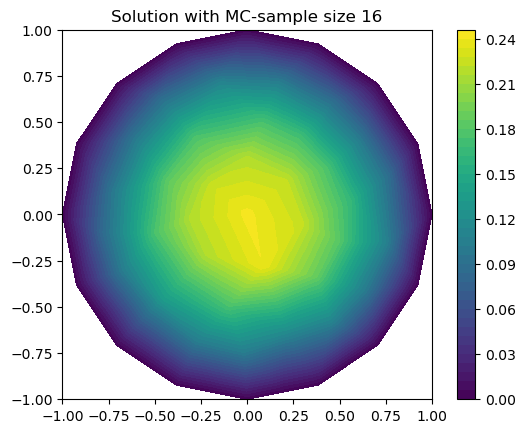

  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
  *** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.


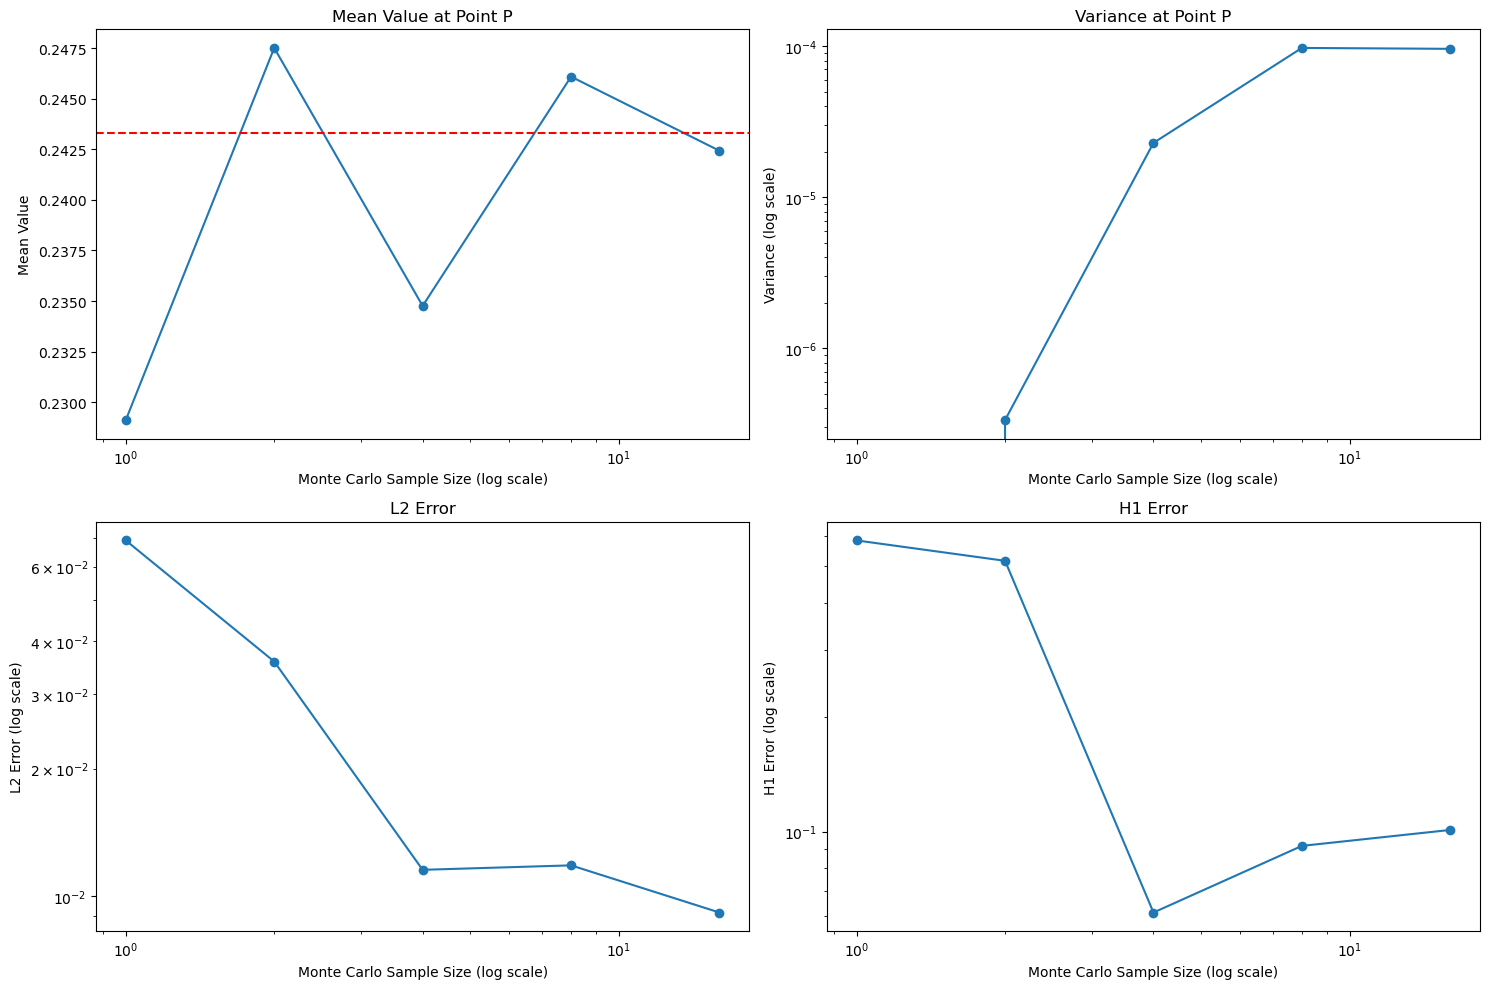

In [29]:
###### Section 3 ######
###### Multiple MC-loop Calculation of samples of the vector field local analysis ######

# Inputs
# [1, 2, 4], 5, 5 takes approximately 7 minutes
# [2, 4, 8, 16], 4, 6 takes approximately 20 minutes
# [1, 2, 4, 8, 16], 5, 5 takes approximately 72 minutes
mc_samples_multiple = [1, 2, 4, 8, 16]
mesh_resolution_fem_multiple = 5
mesh_resolution_fem_true_sol = 5
P = fe.Point(0, 0)

# Calculate samples and solutions
u_sols_in_point_P_mean, u_sols_in_point_P_var, L_2_errors, H_1_errors, u_true_sol_P = mc_multiple_local_calculation(mc_samples_multiple, mesh_resolution_fem_multiple, mesh_resolution_fem_true_sol, P)

# Plot
plt.figure(figsize=(15, 10))

# Mean value plot
plt.subplot(2, 2, 1)
plt.plot(mc_samples_multiple, u_sols_in_point_P_mean, marker='o')
plt.axhline(y=u_true_sol_P, color='r', linestyle='--', label=f'True solution at point x=({P.x()}, {P.y()})')
plt.xscale('log')
plt.title('Mean Value at Point P')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('Mean Value')

# Variance plot
plt.subplot(2, 2, 2)
plt.plot(mc_samples_multiple, u_sols_in_point_P_var, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('Variance at Point P')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('Variance (log scale)')

# L2 error plot
plt.subplot(2, 2, 3)
plt.plot(mc_samples_multiple, L_2_errors, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('L2 Error')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('L2 Error (log scale)')

# H1 error plot
plt.subplot(2, 2, 4)
plt.plot(mc_samples_multiple, H_1_errors, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('H1 Error')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('H1 Error (log scale)')

plt.tight_layout()
plt.show()